# Discussion Figure --- river contributions in North Water polynya / Pikialasorsuaq

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from matplotlib.colors import ListedColormap
import xarray as xr
from scipy.interpolate import interp1d

%matplotlib inline

#### Parameters:

In [2]:
# Domain dimensions:
imin, imax = 1479, 2179
jmin, jmax = 159, 799
isize = imax - imin
jsize = jmax - jmin

month = 8

# Results folders:
folder_ref  = '/data/brogalla/run_storage/Mn-reference-202206/'
folder_glac = '/data/brogalla/run_storage/river-glacial-202206/'

land_color = '#a9a7a2'

# Color maps:
N = 256
vals_glac = np.ones((N, 4))
vals_glac[:, 0] = np.linspace(8/N, 1, N)
vals_glac[:, 1] = np.linspace(115/N, 1, N)
vals_glac[:, 2] = np.linspace(180/N, 1, N)
glac_cmap = ListedColormap(vals_glac).reversed()

In [3]:
# Coordinates and lines for delineating the North Open Water polynya region
NOW_lons = np.array([-79, -75, -70, -67, -67, -70, -72.8, -75, -78, -78.5, -79.2, -79])
NOW_lats = np.array([74.6, 75.2, 75.4, 75.8, 76, 76, 78.2, 78.2, 76.5, 75.5, 74.8, 74.6])

t = np.arange(len(NOW_lons))
ti = np.linspace(0, t.max(), 10 * t.size)

xi = interp1d(t, NOW_lons, kind='cubic')(ti)
yi = interp1d(t, NOW_lats, kind='cubic')(ti)

#### Load files:

In [4]:
# ANHA12 mesh:
mask          = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask         = np.array(mask.variables['tmask'])
land_mask     = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 
tmask_full    = np.empty((12,50,isize,jsize))
tmask_full[:] = tmask[0,:,imin:imax,jmin:jmax]
lon_ANHA12    = np.array(mask.variables['nav_lon'])
lat_ANHA12    = np.array(mask.variables['nav_lat'])
e3t           = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]
hdept         = np.array(mask.variables['hdept'])[0,imin:imax,jmin:jmax]

In [5]:
# Mn model grid:
ref         = nc.Dataset('/data/brogalla/run_storage/Mn-reference-202206/ANHA12_ref-2002_20220422/ANHA12_EXH006_2002_monthly.nc','r')
lon_sub     = np.array(ref.variables['nav_lon'])
lat_sub     = np.array(ref.variables['nav_lat'])
depth_model = np.array(ref.variables['deptht'])

#### Functions:

In [6]:
def load_results():
    # Load climatology of Mn for the reference and glacial enhanced experiments
    
    file = f'climatology.nc'
    path_ref  = f'{folder_ref}/{file}'
    path_glac = f'{folder_glac}/{file}'
    
    with xr.open_dataset(f'{path_ref}') as monthly_ref:
        dmn_ref = monthly_ref['dissolmn'].values[:,0,:,:,:]
    
    with xr.open_dataset(f'{path_glac}') as monthly_glac:
        dmn_glac = monthly_glac['dissolmn'].values[:,0,:,:,:]
    
    return dmn_ref, dmn_glac

In [7]:
def calculate_depth_weighted(var, levels=(0,16)):
    # Input arguments:
    # - var(t,z,y,x) --- variable 
    
    e3t_tile         = np.tile(e3t, (12,1,1,1))
    var_weighted     = var[:,levels[0]:levels[1],:,:]*e3t_tile[:,levels[0]:levels[1],:,:]
    
    # bottom depth (in case of regions shallower than levels[1]):
    depth_bottom     = np.copy(hdept)
    depth_bottom[depth_bottom == 0] = np.nan
    # where bottom is deeper than levels[1], use depth of levels[1]
    depth_bottom[depth_bottom > depth_model[levels[1]-1]] = depth_model[levels[1]-1] 
                 
    # calculate average:
    var_weighted_ave = np.nansum(var_weighted, axis=1) / depth_bottom
    
    # Output:
    # - var_weighted_ave(t,y,x) --- depth-weighted average of variable for each horizontal grid location
    return var_weighted_ave

In [8]:
def calculate_prop(dmn_riv_off, dmn_riv_on):
    # Input arguments:
    # - dmn_riv_on (t,z,y,x) --- concentration of dMn with riverine contribution on
    # - dmn_riv_off(t,z,y,x) --- concentration of dMn with rivers off
    
    # Contribution of rivers / total concentration (with rivers on):
    # should be an elementwise operation
    prop_river  = np.divide(dmn_riv_on - dmn_riv_off, dmn_riv_off)*100*2 # times two so that 100% 
    
    # Output:
    # - prop_river(t,z,y,x)  --- proportional contribution of river to observed [dMn]
    return prop_river

#### Calculations:

In [9]:
dmn_ref, dmn_glac   = load_results()

depth_weighted_ref  = calculate_depth_weighted(dmn_ref, levels=(0,16))
depth_weighted_glac = calculate_depth_weighted(dmn_glac, levels=(0,16))

proportion_glacial = calculate_prop(depth_weighted_ref, depth_weighted_glac)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


#### Figures

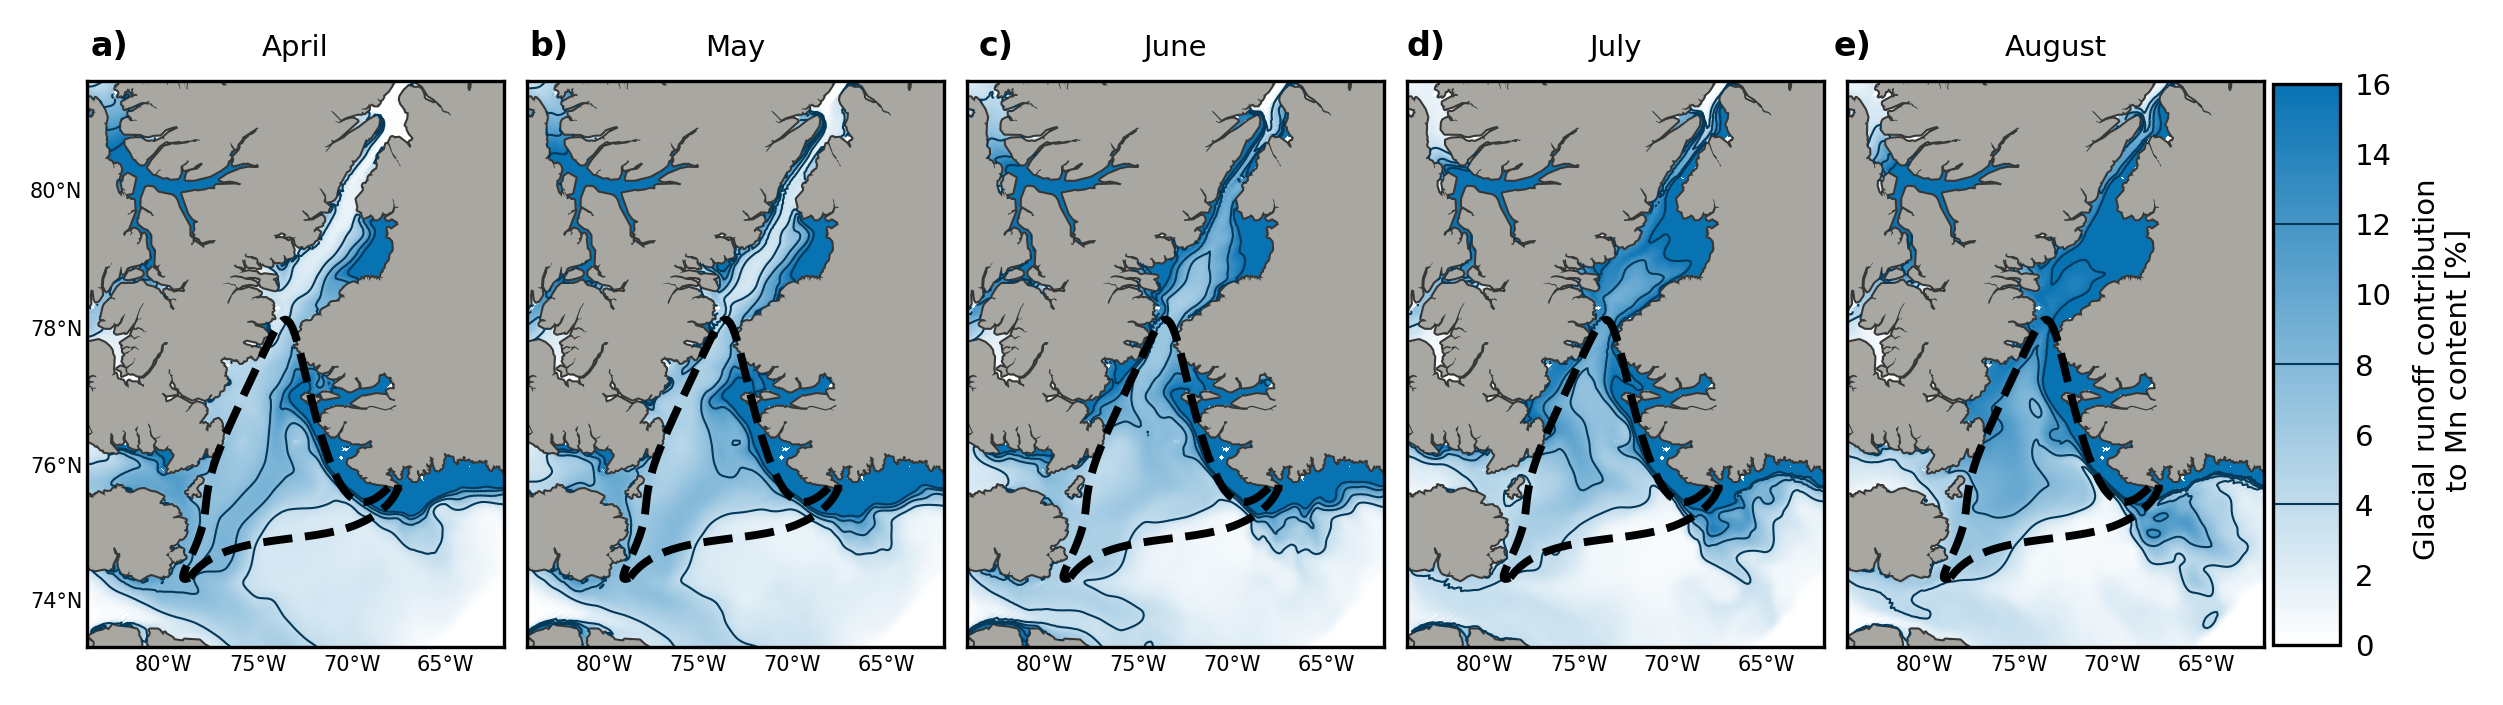

In [12]:
fig, ax, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/polynya.pickle','rb'))

months_ind = [3,4,5,6,7] 
months     = ['April', 'May', 'June', 'July', 'August']

x_model, y_model = proj1(lon_sub, lat_sub)
x_NOW  , y_NOW   = proj1(xi, yi)

# loop over each of the panels
for i, axis in enumerate(ax.ravel()):
    # Coloured contours:
    CS1 = axis.pcolormesh(x_model, y_model, proportion_glacial[months_ind[i],:,:], \
                          vmin=0, vmax=16, cmap=glac_cmap)
    axis.plot(x_NOW, y_NOW, '--k', linewidth=1.9, zorder=3)
    axis.set_title(months[i], fontsize=7)
    
    glac = axis.contour(x_model, y_model, proportion_glacial[months_ind[i],:,:], \
                        levels=[4,8,12,16], \
                        vmin=0, vmax=10, colors='#04395a', linewidths=0.5)
    
# add text labels:
fig.text(0.030, 0.775, 'a)', fontsize=8, weight='bold');
fig.text(0.225, 0.775, 'b)', fontsize=8, weight='bold');
fig.text(0.425, 0.775, 'c)', fontsize=8, weight='bold');
fig.text(0.615, 0.775, 'd)', fontsize=8, weight='bold');
fig.text(0.805, 0.775, 'e)', fontsize=8, weight='bold');

# Colorbars:
cbaxes1 = fig.add_axes([1.0, 0.25, 0.03, 0.5]) 
CBar1   = plt.colorbar(CS1, ax=ax[0], cax=cbaxes1) 
CBar1.add_lines(glac)
CBar1.ax.tick_params(axis='y', length=0, labelsize=7)
CBar1.ax.yaxis.get_offset_text().set(size=7)
CBar1.set_label('Glacial runoff contribution \n to Mn content [%]', labelpad=5, fontsize=7)

fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers-paper-202206/D7-NOW.jpg', bbox_inches='tight', dpi=300)